In [1]:
import tensorflow as tf
import os
import sys
import collections

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)
from rl import action_learner, action_learner_search, value_estimator
import progress_learner
import config
import project
# Need to add this import to load class
from project import Project
from importlib import reload
from rl import block_movement_env
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting

reload(config)
c = config.Config()
c.no_of_loops = 1
# c.constraint_sigma = 0
reload(block_movement_env)
# reload(value_estimator)
reload(action_learner_search)
reload(progress_learner)
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

sess =  tf.Session()

with tf.variable_scope("search") as scope:
    policy_estimator = action_learner_search.PolicyEstimator(c)

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load('../' + p_name)

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True, name = projects[project_name].name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, '../progress_' + project_name + '.mod')

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/Variable:0
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
model/SlideAround/beta1_power:0
model/SlideAround/beta2_power:0
model/SlideAround/model/SlideAround/linear/weight/Adam:0
model/SlideAround/model/SlideAround/linear/weight/Adam_1:0
model/SlideAround/model/SlideAround/linear/bias/Adam:0
model/SlideAround/model/SlideAround/linear/bias/Adam_1:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/

In [2]:
c.progress_threshold=0.92
reload(action_learner_search)
action_lns = {}
for project_name in action_types:
    action_lns[project_name] = action_learner_search.ActionLearner_Search(c, projects[project_name], progress_estimators[project_name], session = sess)

..\experiments\human_evaluation_2d\SlideToward\
action_level = 0
exploration_index = 0
[(0, 0.7472112774848938), (0, 0.72180038690567017), (0, 0.72102051973342896), (0, 0.70660078525543213), (0, 0.69358277320861816), (0, 0.67942118644714355), (0, 0.6533164381980896), (0, 0.65310209989547729), (0, 0.63980388641357422)]
action_level = 1
exploration_index = 0
exploration_index = 1
exploration_index = 2
exploration_index = 3
exploration_index = 4
exploration_index = 5
exploration_index = 6
exploration_index = 7
exploration_index = 8
[(7, 0.89304351806640625), (2, 0.84092086553573608), (0, 0.82869511842727661), (4, 0.82673436403274536), (4, 0.82634449005126953), (2, 0.80009299516677856), (2, 0.79548048973083496), (0, 0.79483675956726074), (4, 0.77348977327346802)]
action_level = 2
exploration_index = 0
exploration_index = 1
exploration_index = 2
exploration_index = 3
exploration_index = 4
exploration_index = 5
exploration_index = 6
exploration_index = 7
exploration_index = 8
[(2, 0.92760968

KeyboardInterrupt: 

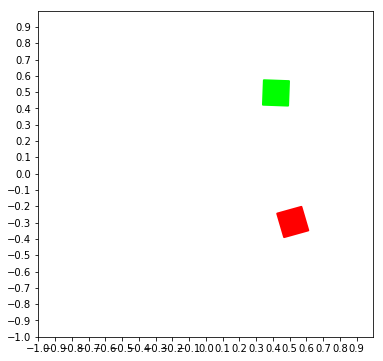

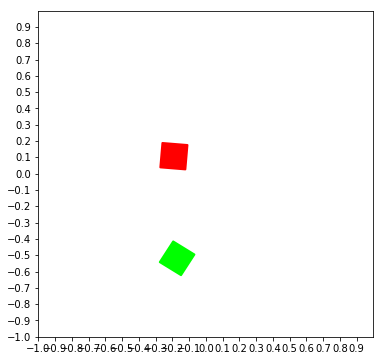

In [14]:
for project_name in action_types:
    prefix = "..\\experiments\\human_evaluation_2d\\" + project_name + "\\"
    print ("============")
    print (prefix)
    al = action_lns[project_name]
    for n in range(2):
        al.env.reset()
        explorations = al.learn_one_setup(verbose = True)
        explorations[0].save(prefix + str(n) + ".dat")
        explorations[0].save_visualization_to_file(prefix + str(n) + ".mp4")

In [3]:
feedback = "..\\experiments\\human_evaluation_2d\\slidearound.txt"

In [4]:
import numpy as np
with open(feedback, 'r') as fh:
    wrong_demonstration_indices = []
    for line in fh:
        values = [int(v) for v in line.split()]
        index = values[0]
        average_score = np.mean(values[1:])
        if average_score <= 2.5:
            wrong_demonstration_indices.append(index)

print (len(wrong_demonstration_indices))
print (wrong_demonstration_indices)

19
[0, 2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 21, 23, 24, 25, 27, 28, 29]


In [5]:
p = progress_estimators["SlideAround"]

In [6]:
reload(block_movement_env)
import pickle

In [7]:
prefix = os.path.join( "..", "experiments", "human_evaluation_2d" , "SlideAround")

In [8]:
al = action_lns["SlideAround"]
prev_demonstrations = []
for index in range(30):
    stored_config_file = os.path.join(prefix, str(index) + ".dat")
    with open(stored_config_file, 'rb') as fh:
        # need this encoding 
        stored_config = pickle.load(fh, encoding='latin-1')
        
        e = block_movement_env.BlockMovementEnv(al.config, al.project.speed, al.project.name, 
                progress_estimator = p, session = al.session)
        e.reset_env_to_state(stored_config['start_config'], stored_config['action_storage'])
        
        prev_demonstrations.append(e)

In [9]:
def create_batch_size ( samples, batch_size ):
    if len(samples) < batch_size:
        repeat = batch_size // len(samples)
        remain = batch_size % len(samples)
        
        q = samples * repeat + samples[:remain]
        return np.stack(q)

In [12]:
negative_samples = []
negative_samples += [prev_demonstrations[index].get_feature_only() for index in [0, 2, 3, 4, 6, 8, 9, 11, 12]]

negative_data = create_batch_size(negative_samples, c.batch_size)

positive_samples = []
positive_samples += [prev_demonstrations[index].get_feature_only() for index in [10, 13]]

positive_data = create_batch_size(positive_samples, c.batch_size)

In [13]:
print (negative_data.shape)
print (positive_data.shape)

(30, 20, 7)
(30, 20, 7)


In [18]:
for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, '../progress_' + project_name + '.mod')

INFO:tensorflow:Restoring parameters from ../progress_SlideAround.mod


In [14]:
for i in range(1):
    print ('-------------------------------')
    lr_decay = c.lr_decay ** i
    print ('Rate = %.5f' % (c.learning_rate * 0.1 * lr_decay))
    p.assign_lr(c.learning_rate * lr_decay, sess = sess)
    
#     # Update with negative samples
    p.update(negative_data, np.zeros(c.batch_size), sess = sess)
    
#     # Update with positive samples
    p.update(positive_data, np.ones(c.batch_size), sess = sess)

-------------------------------
Rate = 0.00010


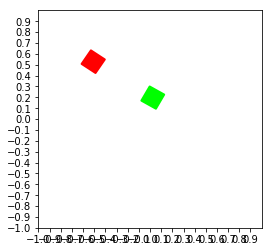

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.42125762  0.78644046  1.26953124]
[[ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]]
Progress = 0.70; reward = 0.74


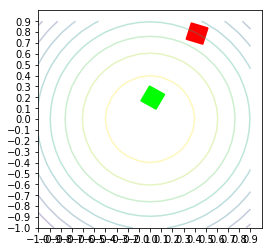

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.42125762  0.78644046  1.26953124]
[[ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]]
Progress = 0.69; reward = -0.02


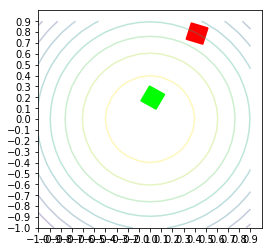

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.71070855  0.22431777 -0.17699204]
[[ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0. ]
 [ 1.  -1.  -1.   0.   1.   0.   0. ]
 [ 0.  -1.  -1.   0.   1.   0.   0. ]
 [ 0.   0.  -1.   0.   1.   0.  -0.5]
 [ 1.  -1.  -1.   0.   1.   0.  -0.5]
 [ 0.   0.  -1.   0.   1.   0.  -0.5]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 1.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]]
Progress = 0.16; reward = -0.61


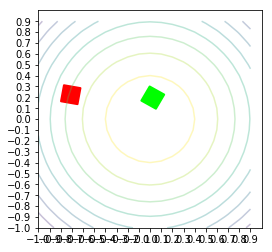

In [15]:
prev_demonstrations[12].replay()

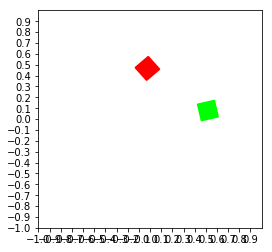

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.79469355  0.29144756  0.01753818]
[[ 0.   0.   0.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.29; reward = 0.40


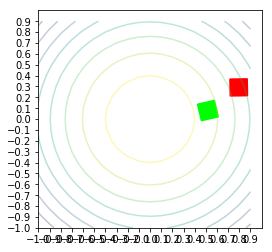

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.57477568 -0.44249176  0.26738601]
[[ 0.   0.   0.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.81; reward = 0.41


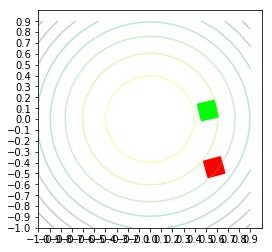

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.5536921   0.04493412  0.80928455]
[[ 0.   0.   0.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [-1.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.   1.  -1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   2.   1.   0.  -1.   0.   0.5]
 [ 0.   2.   1.   0.  -1.   0.   1. ]]
Progress = 0.84; reward = 0.02


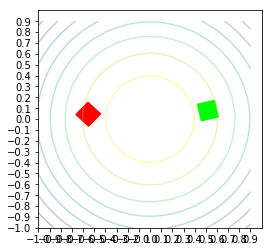

In [16]:
prev_demonstrations[10].replay()

In [14]:
negative_samples[0]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. , -1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  0. , -1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  0. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [-1. ,  0. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  0. , -1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. , -1. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [ 1. , -1. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. , -2. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. , -1. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. , -1. ,  0. ,  1. ,  0. ,  0.5],
       [ 1. , -1. , -1. ,  0. ,  1. ,  0. ,  0.5],
       [ 0. ,  0. , -1. ,  0. ,  1. ,  0. ,  0.5],
       [ 1. ,  1. ,  1. ,  0. ,  1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. ,  1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. ,  1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. ,  1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. ,  1. ,  0. ,  0.5],
       [-1. ,  1. , -1. ,  0. ,

In [15]:
positive_samples[0]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. , -2. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. , -1. , -1. ,  0. ,  0. ,  0. ,  0.5],
       [-1. , -1. , -1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. , -1. , -1. ,  0. , -1. ,  0. ,  0. ],
       [-1. ,  0. , -1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  0. , -1. ,  0. ,  0. ],
       [-1. , -1. , -1. ,  0. , -1. ,  0. ,  0. ],
       [-1. ,  1. , -1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0. ],
       [-1. ,  1. ,  1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  0. , -1. ,  0. ,  0. ],
       [-1. ,  0. , -1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [-1. ,  1. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  1. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [ 0. ,  2. ,  1. ,  0. , -1. ,  0. ,  0.5],
       [-1. , -4. , -1. ,  0. ,

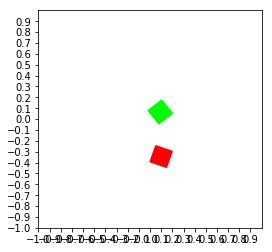

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.16522665 -0.26798334  0.11862508]
[[ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]]
Progress = 0.53; reward = 0.58


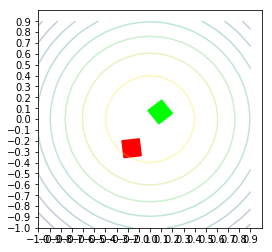

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.68967379  0.10547168  0.71620143]
[[ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [ 1.   0.  -1.   0.   1.   0.  -0.5]
 [ 0.   0.  -1.   0.   1.   0.  -0.5]
 [ 0.  -1.  -1.   0.   1.   0.  -0.5]
 [ 1.   0.  -1.   0.   1.   0.  -0.5]
 [ 0.   0.   1.   0.   1.   0.   0. ]
 [ 0.   1.   1.   0.   1.   0.   0. ]
 [ 1.   0.   1.   0.   1.   0.   0. ]
 [ 0.   1.   1.   0.   1.   0.   0. ]
 [ 0.   1.   1.   0.   1.   0.   0. ]
 [ 0.   0.   1.   0.   1.   0.   0. ]
 [ 0.   1.   1.   0.   1.   0.   0. ]
 [ 0.   1.   1.   0.   1.   0.   0. ]
 [ 0.   0.   1.   0.   1.   0.   0. ]]
Progress = 0.09; reward = -0.53


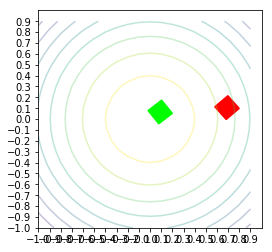

In [17]:
prev_demonstrations[16].replay()

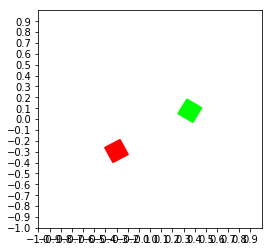

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.0509483   0.85825823 -0.29786026]
[[ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [-1.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [-1.   0.   0.   0.  -1.   0.  -1. ]
 [ 0.   1.   1.   0.  -1.   0.  -1. ]
 [ 0.   0.   1.   0.  -1.   0.  -1. ]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]]
Progress = 0.71; reward = 0.74


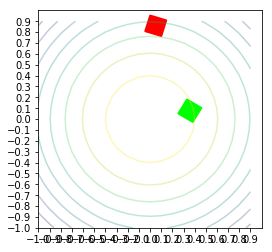

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.0509483   0.85825823 -0.29786026]
[[ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [-1.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.  -1.   0.  -1.   0.  -1. ]
 [-1.   0.   0.   0.  -1.   0.  -1. ]
 [ 0.   1.   1.   0.  -1.   0.  -1. ]
 [ 0.   0.   1.   0.  -1.   0.  -1. ]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0.5]]
Progress = 0.70; reward = -0.01


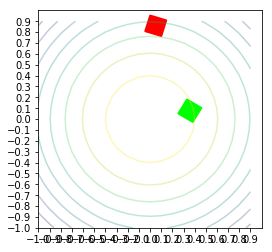

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.07171718 -0.86668351 -0.23004993]
[[ 0.   0.   0.   0.   0.   0.  -0.5]
 [-1.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [ 0.  -1.  -1.   0.  -1.   0.  -1. ]
 [-1.   1.  -1.   0.  -1.   0.  -1. ]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   0.5]
 [ 0.   2.   1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   1.   0.   0.5]
 [ 0.  -1.  -1.   0.   1.   0.   0.5]
 [ 1.  -1.  -1.   0.   1.   0.   0.5]
 [ 0.   0.  -1.   0.   1.   0.   0.5]
 [ 1.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]]
Progress = 0.13; reward = -0.64


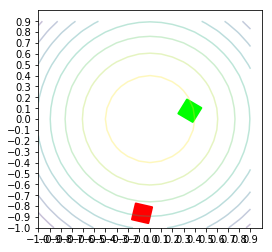

In [18]:
prev_demonstrations[17].replay()

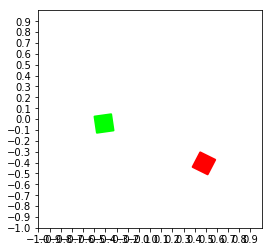

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.42674679  0.41249632  1.04070635]
[[ 0.  0.  0.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 1.  0. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  1.]]
Progress = 0.16; reward = 0.08


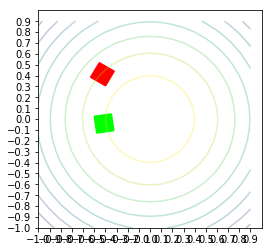

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.42674679  0.41249632  1.04070635]
[[ 0.  0.  0.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 1.  0. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  1.]]
Progress = 0.12; reward = 0.05


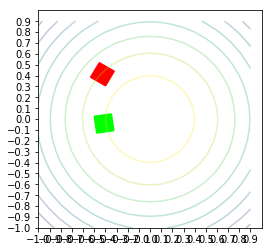

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.10619942 -0.13316323  1.08050981]
[[ 0.  0.  0.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  1.  0.  1.]
 [ 1. -1. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  1.]
 [ 0.  0. -1.  0.  1.  0.  1.]
 [ 0. -1. -1.  0.  0.  0.  1.]
 [-1. -1. -1.  0. -1.  0.  1.]
 [ 0. -1. -1.  0. -1.  0.  1.]
 [-1.  0. -1.  0. -1.  0.  1.]
 [ 0.  1.  1.  0. -1.  0.  1.]
 [ 0.  1.  1.  0. -1.  0.  1.]]
Progress = 0.09; reward = 0.13


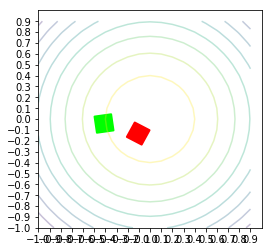

In [19]:
prev_demonstrations[21].replay()

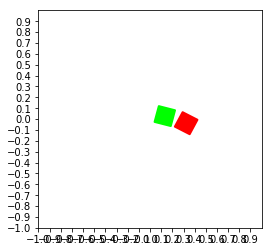

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[ 0.84831608  0.58845618  0.02700747]
[[ 0.   0.   1.   0.   1.   0.  -0.5]
 [ 0.   1.   1.   0.   1.   0.  -0.5]
 [ 0.   0.   1.   0.   1.   0.  -0.5]
 [ 0.   1.   1.   0.   1.   0.  -0.5]
 [ 0.   0.   1.   0.   1.   0.  -0.5]
 [ 0.   0.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 1.   0.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   0.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   0.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   0.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   0.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   0.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]]
Progress = 0.16; reward = 0.13


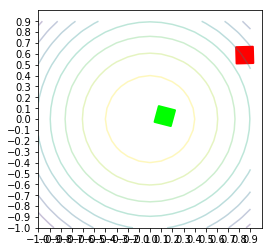

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.53520214 -0.04011001  0.15527732]
[[ 0.   1.   1.   0.   1.   0.  -0.5]
 [ 1.   2.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 1.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   1.   0.   0.5]
 [ 1.   0.  -1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 1.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]]
Progress = 0.56; reward = 0.46


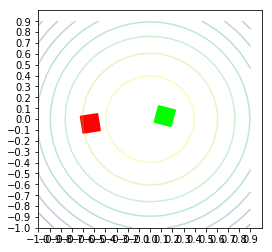

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.60372459 -0.02319774  0.40270725]
[[ 0.   1.   1.   0.   1.   0.  -0.5]
 [ 1.   1.   1.   0.   1.   0.  -1. ]
 [ 0.   2.   1.   0.   1.   0.  -1. ]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   0.   0.   0.   1.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -1.  -1.   0.   0.   0.   0.5]
 [ 0.  -2.  -1.   0.   0.   0.   0.5]
 [ 1.  -1.  -1.   0.   1.   0.   0.5]
 [ 0.  -1.  -1.   0.   1.   0.   0.5]
 [ 1.   1.  -1.   0.   1.   0.   0.5]
 [ 1.   0.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.   0.5]
 [ 0.   2.   1.   0.   1.   0.   0.5]
 [ 0.   1.   1.   0.   1.   0.  -1. ]]
Progress = 0.58; reward = 0.01


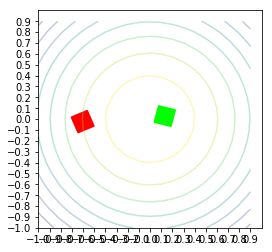

In [20]:
prev_demonstrations[18].replay()

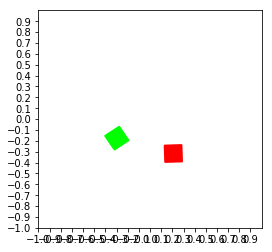

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.66812472 -0.52930078  0.6571263 ]
[[ 0.   0.   0.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.   0.   0.  -0.5]
 [-1.   0.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [-1.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.69; reward = 0.76


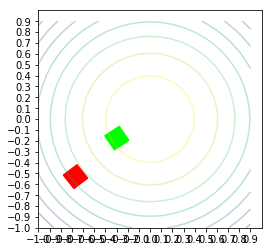

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.50539326  0.43798172  1.44245024]
[[-1.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [-1.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [-1.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [-1.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [-1.   1.   1.   0.  -1.   0.   1. ]]
Progress = 0.73; reward = -0.05


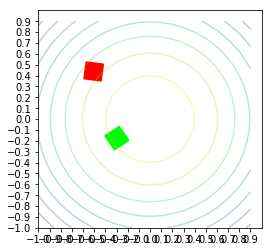

(array([ 0.,  0.,  0.], dtype=float32), array([ 2. ,  2. ,  0.5], dtype=float32))
[-0.40903607  0.60848286 -0.448662  ]
[[ 0.   0.   0.   0.   0.   0.  -0.5]
 [-1.  -1.  -1.   0.   0.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [ 0.  -1.  -1.   0.  -1.   0.  -0.5]
 [-1.   0.  -1.   0.  -1.   0.  -0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [-1.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [-1.   0.   1.   0.  -1.   0.   0.5]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [ 0.   1.   1.   0.  -1.   0.   1. ]
 [-1.   2.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0.5]]
Progress = 0.74; reward = -0.00


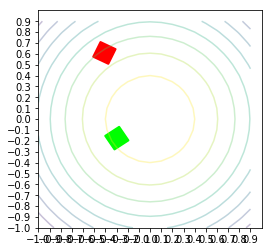

In [21]:
prev_demonstrations[19].replay()